In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from copy import copy
from scipy import stats
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score

Преобразуем некоторые данные для дальнейшей работы с ними. У колонки с зарплатами уберем доллар, преобразуем в число. Рост возьмем в метрах, вес в килограммах, всё преобразовываем в числа. Создадим одну новую колонку для возраста игроков. Также создадим колонку разбиения зарплат по группам. Все эти данные понадобятся нам для предсказания.

In [2]:
nbaDataFrame = pd.read_csv('nba2k20-full.csv')
nbaDataFrame.salary = nbaDataFrame.salary.apply(lambda x: int(x[1:]))
nbaDataFrame.height = nbaDataFrame.height.apply(lambda x: float(x.split('/')[1]))
nbaDataFrame.weight = nbaDataFrame.weight.apply(lambda x: float(x.split('/')[1][:-3]))

birthdays = nbaDataFrame.b_day.apply(lambda x: int(x.split('/')[2]))

current_year = 2020
years = []
for birthday in birthdays:
    if 0 <= birthday <= 50:
        years.append(current_year - (2000 + birthday))
    else :
        years.append(current_year - (1900 + birthday))

def createSalaryGroup(currentSalary):
    if currentSalary >= 25000000:
        return 1
    if 15000000 <= currentSalary < 25000000:
        return 2
    if 5000000 <= currentSalary < 15000000:
        return 3
    return 4

nbaDataFrame = nbaDataFrame.assign(salaryGroup=nbaDataFrame.salary.apply(lambda x: createSalaryGroup(x)))
nbaDataFrame = nbaDataFrame.assign(years=years)
nbaDataFrame

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college,salaryGroup,years
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,2.06,113.4,37436858,USA,2003,1,1,NaN,1,36
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,2.01,102.1,32742000,USA,2011,1,15,San Diego State,1,29
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,2.11,109.8,25842697,Greece,2013,1,15,NaN,1,26
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,2.08,104.3,37199000,USA,2007,1,2,Texas,1,32
4,James Harden,96,#13,Houston Rockets,G,08/26/89,1.96,99.8,38199000,USA,2009,1,3,Arizona State,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,Brandon Goodwin,68,#0,Atlanta Hawks,G,10/02/95,1.83,81.6,522738,USA,2018,Undrafted,Undrafted,Florida Gulf Coast,4,25
425,Michael Frazier,68,#21,Houston Rockets,G,03/08/94,1.91,90.7,79568,USA,2015,2,60,Florida,4,26
426,Kostas Antetokounmpo,68,#37,Los Angeles Lakers,F,11/20/97,2.08,90.7,79568,Greece,2018,Undrafted,Undrafted,Dayton,4,23
427,Jalen Lecque,68,#0,Phoenix Suns,G,06/13/00,1.91,86.2,898310,USA,2019,Undrafted,Undrafted,NaN,4,20


In [3]:
rating = nbaDataFrame.rating
draftYear = nbaDataFrame.draft_year
salary = nbaDataFrame.salary
salaryGroup = nbaDataFrame.salaryGroup
print(salaryGroup)

0      1
1      1
2      1
3      1
4      1
      ..
424    4
425    4
426    4
427    4
428    4
Name: salaryGroup, Length: 429, dtype: int64


Массив Х, по которому будем предсказывать, будет состоять из 5 данных - рейтинг, рост, вес, год драфта, и возраст.
Массив y - группа зарплаты, её будем предсказывать

In [4]:
X = copy(nbaDataFrame).drop(['full_name', 'jersey', 'team', 'position', 'b_day',
                            'salary', 'country', 'draft_round', 'draft_peak', 'college', 'salaryGroup'], axis=1).values.tolist()
print(X[0])
y = salaryGroup.values.tolist()
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3)

[97.0, 2.06, 113.4, 2003.0, 36.0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 4, 3, 3, 1, 4, 1, 2, 1, 1, 1, 3, 3, 2, 2, 1, 1, 2, 1, 1, 1, 4, 4, 4, 4, 3, 3, 2, 2, 2, 3, 1, 3, 3, 2, 1, 1, 3, 3, 3, 1, 3, 2, 2, 3, 3, 2, 3, 3, 4, 2, 1, 3, 3, 2, 1, 2, 4, 1, 3, 3, 3, 3, 4, 4, 3, 2, 3, 3, 4, 2, 4, 2, 3, 3, 3, 4, 4, 3, 2, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 4, 3, 2, 4, 2, 4, 3, 3, 2, 3, 2, 2, 2, 2, 4, 3, 3, 3, 3, 3, 1, 4, 3, 3, 4, 3, 3, 3, 2, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 2, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 2, 4, 4, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 2, 4, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 3, 4, 2, 4, 3, 3, 4, 3, 3, 3, 4, 1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 4, 3, 4, 2, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Для предсказания будем использовать алгоритм Forest. Посмотрим его работу, используя метрики accuracy, precision и f1.

In [15]:
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

# Обучим классификаторы на тренировочных данных
for clf in [knn_clf, svm_clf, forest_clf]:
    clf.fit(X_train, y_train)

# Получим значение метки для тестового набора
knn_pred = knn_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test)
forest_pred = forest_clf.predict(X_test)

# Посчитаем метрику качества
forest_acc_score = accuracy_score(y_test, forest_pred)

forest_precision = precision_score(y_test, forest_pred, average="weighted")

forest_f1 = f1_score(y_test, forest_pred, average='weighted')

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('Forest_accuracy', forest_acc_score),
    ('Forest_precision', forest_precision),
    ('Forest_f1', forest_f1)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. Forest_accuracy: 0.7286821705426356
2. Forest_f1: 0.7116417512982312
3. Forest_precision: 0.7040415568567343


Попробуем найти нормальный признак. Самый близкий получился рост. Известно, что в любой группе людей их рост должен быть нормальным. Проверим через stats.normaltest - выдаёт 0.08, что мало. Однако на гистограмме видим, что распределение нормальное

In [6]:
stats.normaltest(nbaDataFrame.height)

NormaltestResult(statistic=4.846177468074185, pvalue=0.08864738596500196)

(array([ 2., 12., 31., 73., 95., 91., 70., 49.,  4.,  2.]),
 array([1.75 , 1.799, 1.848, 1.897, 1.946, 1.995, 2.044, 2.093, 2.142,
        2.191, 2.24 ]),
 <BarContainer object of 10 artists>)

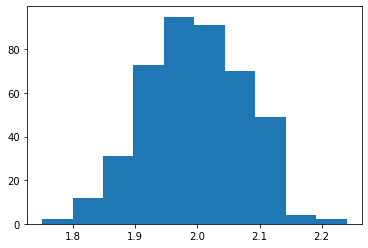

In [7]:
import matplotlib.pyplot as plt
plt.hist(nbaDataFrame.height)